In [1]:
%matplotlib inline

In [2]:
import numpy as np
from io import StringIO
from astropy.constants import c
import matplotlib.pyplot as plt
import itertools
from astropy.coordinates import Angle
from astropy import units as u
from astropy.coordinates import EarthLocation, AltAz, ITRS, CartesianRepresentation

In [3]:
def calc_R(H,dec):
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec*np.ones_like(H))],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec*np.ones_like(H))]])

    return R

In [4]:
def calc_RR(H,dec):
    
    """
    function to calculate rotation matrix
    """
    
    R = [[np.sin(H), np.cos(H), 0],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec)],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec)]]
    
    return np.array(R)

In [5]:
def _altaz_to_earthlocation(altaz):
    local_itrs = altaz.transform_to(ITRS(location=altaz.location))
    itrs = ITRS(local_itrs.cartesian + altaz.location.get_itrs().cartesian)
    return itrs.earth_location

In [6]:
def _earthlocation_to_altaz(location, reference_location):
    # See
    # https://docs.astropy.org/en/stable/coordinates/common_errors.html#altaz-calculations-for-earth-based-objects
    # for why this is necessary and we cannot just do
    # `get_itrs().transform_to(AltAz())`
    itrs_cart = location.get_itrs().cartesian
    itrs_ref_cart = reference_location.get_itrs().cartesian
    local_itrs = ITRS(itrs_cart - itrs_ref_cart, location=reference_location)
    return local_itrs.transform_to(AltAz(location=reference_location))

In [7]:
def local_to_earth_location(x, y, z, reference_location):
    cart = CartesianRepresentation(x, y, z)
    altaz = AltAz(cart, location=reference_location)
    return _altaz_to_earthlocation(altaz)

In [8]:
def earth_location_to_local(location, reference_location):
    altaz = _earthlocation_to_altaz(location, reference_location)
    return altaz.cartesian.xyz

In [ ]:
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 16

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": "pdflatex",  # default is xetex
    }
)

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize

In [9]:
antenna_config_path = "/usr/local/bin/CASA/casa-6.5.5-21-py3.8/data/alma/simmos/"

In [10]:
antenna_config_file = antenna_config_path + "vla.d.cfg"

In [11]:
dtype=[('x','f4'),('y','f4'),('z','f4'),('D','f4'),('id','S5')]

In [12]:
data = np.loadtxt(antenna_config_file, dtype=dtype)

In [ ]:
data

In [13]:
data_earth_loc = EarthLocation.from_geocentric(data["x"], data["y"], data["z"], u.m)

In [ ]:
data_earth_loc

In [ ]:
keck = EarthLocation.of_site('vla')

In [ ]:
keck

In [14]:
telescope_center = data_earth_loc.of_site("vla")
#telescope_center = EarthLocation.from_geocentric(-1.60119e+06, -5.04198e+06, 3.55488e+06, u.m)

In [ ]:
telescope_center

In [15]:
x,y,z = earth_location_to_local(data_earth_loc, telescope_center)

In [16]:
data["x"] = -x
data["y"] = y
data["z"] = z

In [ ]:
data

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

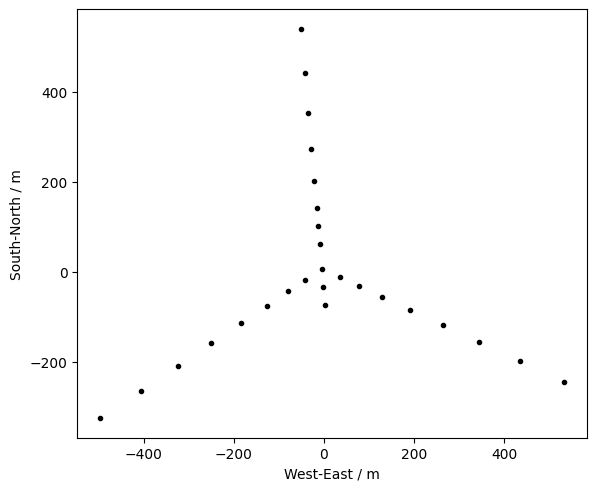

In [19]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(data["y"], -data["x"], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)
#ax.set_aspect('equal')

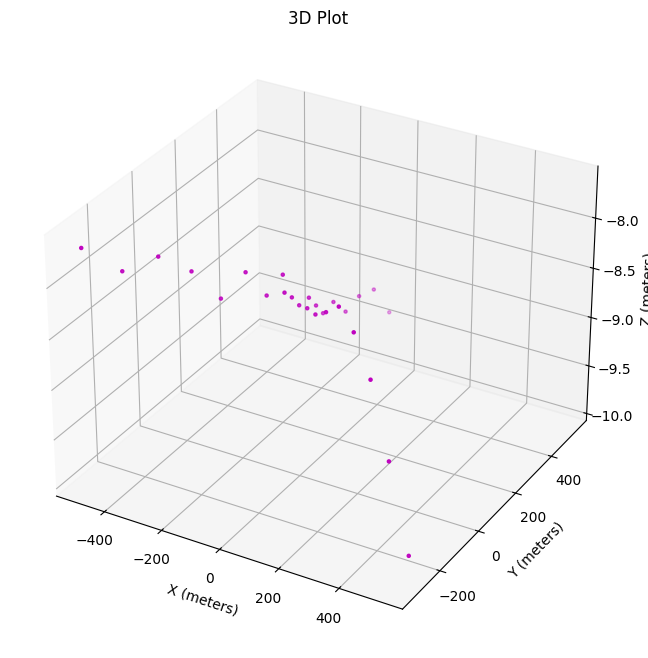

In [21]:
fig4 = plt.figure(figsize=(10, 8))
ax4 = fig4.add_subplot(111, projection='3d')
ax4.scatter(data["y"], -data["x"], data["z"], c='m', marker='.')

# Set labels and title
ax4.set_xlabel('X (meters)')
ax4.set_ylabel('Y (meters)')
ax4.set_zlabel('Z (meters)')
ax4.set_title('3D Plot')
plt.show()

In [22]:
antenna_xyz = np.vstack([data["x"], data["y"], data["z"]]).T

In [ ]:
antenna_xyz

In [23]:
antenna_id = np.arange(0, len(data["x"]))

In [24]:
antenna_pair_combinations = np.fromiter(itertools.chain(*itertools.combinations(antenna_id, 2)), dtype=int).reshape(-1,2)

In [25]:
baselines = np.vstack([antenna_xyz[antenna_pair_combinations[:,0]] - antenna_xyz[antenna_pair_combinations[:,1]], 
                       antenna_xyz[antenna_pair_combinations[:,1]] - antenna_xyz[antenna_pair_combinations[:,0]]])

In [ ]:
baselines

In [26]:
HA = np.arange(-180.*(np.pi/180.), 180.*(np.pi/180.), 0.1*(np.pi/180.))  # [radians]
#dec = Angle('18:13:57.65 degrees').to(u.rad).value
dec = np.radians(45)

In [27]:
R_complete = calc_R(HA, np.radians(20))

In [28]:
UV_coverage = np.dot(R_complete.T, baselines.T)

Text(0.5, 0.5, 'v (m)')

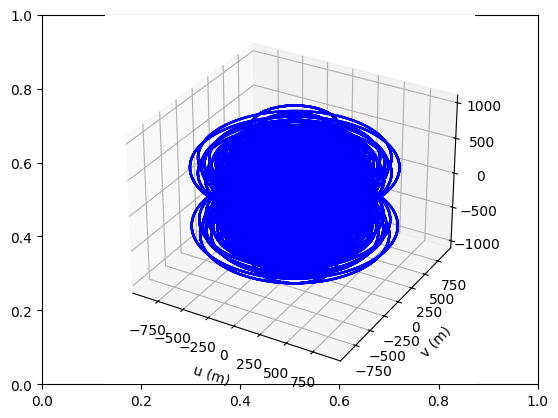

In [29]:
fig, ax = plt.subplots()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(UV_coverage[:, 0],UV_coverage[:,1],UV_coverage[:,2],  marker=".",s=2, c='b')
ax.set_xlabel('u (m)') 
ax.set_ylabel('v (m)')

Text(0, 0.5, 'v (m)')

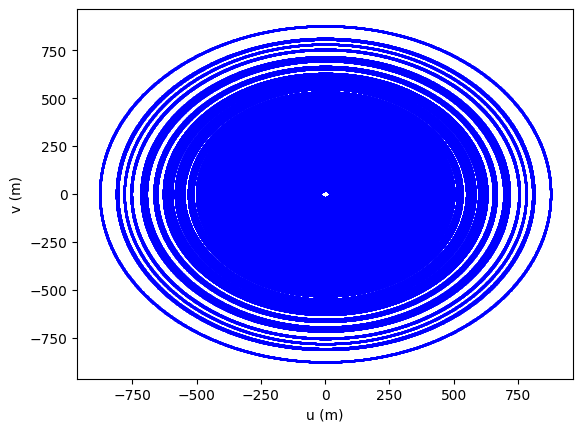

In [30]:
fig, ax = plt.subplots()

ax.scatter(UV_coverage[:, 0],UV_coverage[:,1],  marker=".",s=2, c='b')
ax.set_xlabel('u (m)') 
ax.set_ylabel('v (m)')

In [ ]:
"""import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

#x = np.arange(0, len(HA))
def animate(t):
    plt.cla()
    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")

matplotlib.animation.FuncAnimation(fig, animate, frames=len(HA))"""
